In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from data_process import tokenizers, utils
from nanoGPT.model import  GPT, GPTConfig
from lightning_training import LightningGPT, GamesDataModule, GamesDataset
import pytorch_lightning as pl
import torch
import os

In [6]:
headers = ["index", "id", "date", "white_elo", "black_elo", "result", "ply", "ply_30s", "piece_uci"]

df = pd.read_csv("./data/csv/uniform_elo_distribution/test.csv", delimiter=";", header=None, names=headers)

avg_elo = (df["white_elo"] + df["black_elo"]) / 2
df["avg_elo"] = avg_elo
df

,index,id,date,white_elo,black_elo,result,ply,ply_30s,piece_uci,avg_elo
0,74497,?,2021.12.05,2523,2684,0-1,52,-1,Pd2d4 39 39 Pd7d5 39 39 Nb1c3 39 39 Pc7c6 39 3...,2603.5
1,74505,?,2021.12.05,2623,2581,0-1,96,-1,Pd2d4 39 39 Ng8f6 39 39 Pc2c4 39 39 Pe7e6 39 3...,2602.0
2,74508,?,2021.12.05,2757,2670,1/2-1/2,106,-1,Pd2d4 39 39 Pd7d5 39 39 Ke1d2 39 39 Pe7e5 39 3...,2713.5
3,74510,?,2021.12.05,2627,2666,0-1,96,-1,Pd2d4 39 39 Ng8f6 39 39 Bc1f4 39 39 Pd7d5 39 3...,2646.5
4,74517,?,2021.12.05,2666,2571,1-0,47,-1,Pe2e4 39 39 Pc7c5 39 39 Ng1f3 39 39 Nb8c6 39 3...,2618.5
...,...,...,...,...,...,...,...,...,...,...
99995,14202188,CJayVtXh,2024.12.05,1303,879,1-0,33,-1,Pe2e4 39 39 Pe7e6 39 39 Ng1f3 39 39 Pf7f6 39 3...,1091.0
99996,14202189,XkroYjvj,2024.12.05,1099,1209,0-1,59,-1,Pe2e4 39 39 Pe7e5 39 39 Ng1f3 39 39 Nb8c6 39 3...,1154.0
99997,14202191,DWLSh6Wn,2024.12.05,1070,1019,0-1,48,-1,Pe2e4 39 39 Pe7e5 39 39 Ng1f3 39 39 Ng8f6 39 3...,1044.5
99998,14202194,g7tUv4Rt,2024.12.05,1211,1173,1-0,9,-1,Pe2e4 39 39 Pd7d5 39 39 Bf1c4 39 39 Pe7e5 39 3...,1192.0


In [7]:
n_games = len(df)
print(f"Number of games: {n_games}")


n_elo_games = len(df[(df.avg_elo >= 0) & (df.avg_elo < 1000)])

print(f"Number of games between 0000 and 1000: ", n_elo_games, "(", n_elo_games/n_games*100, "%)")

step = 200


for elo in range(1000, 4000, step):
    n_elo_games = len(df[(df.avg_elo >= elo) & (df.avg_elo < elo+step)])
    print(f"Number of games between {elo} and {elo+step}: ", n_elo_games, "(", n_elo_games/n_games*100, "%)")
    # print(f"Number of games between {elo} and {elo+100}: ", len(df[(df.avg_elo >= elo) & (df.avg_elo < elo+100)]))

# len(df[(df.avg_elo >= 1000) & (df.avg_elo < 1100)])

Number of games: 100000
Number of games between 0000 and 1000:  9979 ( 9.979000000000001 %)
Number of games between 1000 and 1200:  9990 ( 9.99 %)
Number of games between 1200 and 1400:  10004 ( 10.004 %)
Number of games between 1400 and 1600:  10001 ( 10.001 %)
Number of games between 1600 and 1800:  10006 ( 10.006 %)
Number of games between 1800 and 2000:  9995 ( 9.995 %)
Number of games between 2000 and 2200:  10017 ( 10.017 %)
Number of games between 2200 and 2400:  9992 ( 9.991999999999999 %)
Number of games between 2400 and 2600:  9999 ( 9.998999999999999 %)
Number of games between 2600 and 2800:  10012 ( 10.012 %)
Number of games between 2800 and 3000:  5 ( 0.005 %)
Number of games between 3000 and 3200:  0 ( 0.0 %)
Number of games between 3200 and 3400:  0 ( 0.0 %)
Number of games between 3400 and 3600:  0 ( 0.0 %)
Number of games between 3600 and 3800:  0 ( 0.0 %)
Number of games between 3800 and 4000:  0 ( 0.0 %)


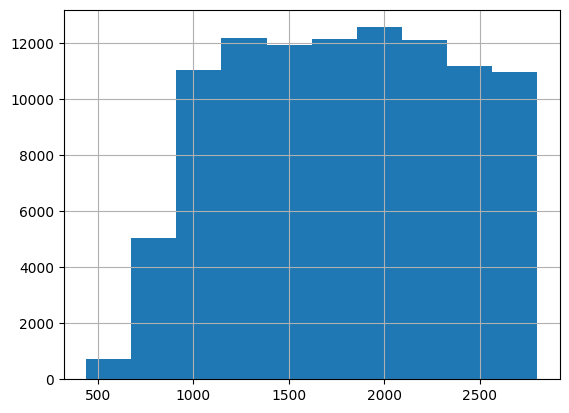

In [8]:
plt.hist(df.avg_elo, bins=10)
plt.grid()
plt.show()

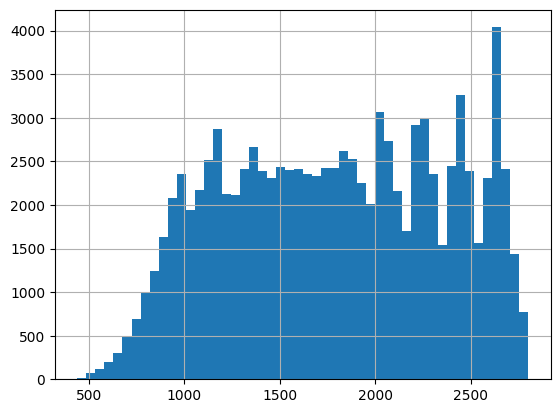

In [10]:
plt.hist(df.avg_elo, bins=50)
plt.grid()
plt.show()

In [11]:
df = df.sample(n = 10000, random_state=42)

In [4]:
df['piece_uci'] = utils.remove_material_tokens(df.piece_uci)

In [5]:
games = utils.remove_material_tokens(df.piece_uci)
games

75721    Pd2d4 Ng8f6 Ng1f3 Pc7c5 Pe2e3 Pb7b6 Bf1d3 Bc8b...
80184    Pd2d4 Ng8f6 Nb1c3 Pc7c5 Pd4d5 Pd7d6 Pe2e4 Pg7g...
19864    Ng1f3 Pc7c6 Pg2g3 Pd7d5 Pd2d3 Pe7e6 Bf1g2 Bf8d...
76699    Pc2c4 Pe7e6 Nb1c3 Pd7d5 Pd2d4 Pc7c5 Pc4d5 Pe6d...
92991    Pe2e4 Pd7d5 Pe4d5 Qd8d5 Nb1c3 Qd5d8 Ng1f3 Pa7a...
                               ...                        
5002     Pd2d4 Pd7d5 Nb1c3 Ng8f6 Bc1f4 Pc7c5 Pe2e3 Nb8c...
30151    Pc2c4 Pe7e6 Ng1f3 Pd7d5 Pg2g3 Ng8f6 Bf1g2 Bf8e...
93194    Pe2e4 Pe7e5 Pd2d3 Nb8c6 Nb1c3 Ng8f6 Ng1f3 Bf8b...
73199    Pe2e4 Pd7d5 Pe4d5 Qd8d5 Nb1c3 Qd5d6 Bf1c4 Ng8f...
74479    Pd2d4 Ng8f6 Nb1c3 Pg7g6 Ng1f3 Pd7d5 Ph2h4 Ph7h...
Name: piece_uci, Length: 10000, dtype: object

In [6]:
games_with_elo = utils.add_elo_token_to_games(games, df.white_elo, df.black_elo)
games_with_elo

75721    2400 2400 Pd2d4 Ng8f6 Ng1f3 Pc7c5 Pe2e3 Pb7b6 ...
80184    1900 2000 Pd2d4 Ng8f6 Nb1c3 Pc7c5 Pd4d5 Pd7d6 ...
19864    2100 2100 Ng1f3 Pc7c6 Pg2g3 Pd7d5 Pd2d3 Pe7e6 ...
76699    2400 2400 Pc2c4 Pe7e6 Nb1c3 Pd7d5 Pd2d4 Pc7c5 ...
92991    1200 1100 Pe2e4 Pd7d5 Pe4d5 Qd8d5 Nb1c3 Qd5d8 ...
                               ...                        
5002     2700 2500 Pd2d4 Pd7d5 Nb1c3 Ng8f6 Bc1f4 Pc7c5 ...
30151    2200 2100 Pc2c4 Pe7e6 Ng1f3 Pd7d5 Pg2g3 Ng8f6 ...
93194    1000 1100 Pe2e4 Pe7e5 Pd2d3 Nb8c6 Nb1c3 Ng8f6 ...
73199    2400 2400 Pe2e4 Pd7d5 Pe4d5 Qd8d5 Nb1c3 Qd5d6 ...
74479    2500 2500 Pd2d4 Ng8f6 Nb1c3 Pg7g6 Ng1f3 Pd7d5 ...
Length: 10000, dtype: object

In [7]:
tokenizer = tokenizers.FullMoveTokenizerWithElo()
games_without_elo = tokenizer.unk_elo_token + " " + tokenizer.unk_elo_token + " " + games
games_without_elo

75721    [UNK_ELO] [UNK_ELO] Pd2d4 Ng8f6 Ng1f3 Pc7c5 Pe...
80184    [UNK_ELO] [UNK_ELO] Pd2d4 Ng8f6 Nb1c3 Pc7c5 Pd...
19864    [UNK_ELO] [UNK_ELO] Ng1f3 Pc7c6 Pg2g3 Pd7d5 Pd...
76699    [UNK_ELO] [UNK_ELO] Pc2c4 Pe7e6 Nb1c3 Pd7d5 Pd...
92991    [UNK_ELO] [UNK_ELO] Pe2e4 Pd7d5 Pe4d5 Qd8d5 Nb...
                               ...                        
5002     [UNK_ELO] [UNK_ELO] Pd2d4 Pd7d5 Nb1c3 Ng8f6 Bc...
30151    [UNK_ELO] [UNK_ELO] Pc2c4 Pe7e6 Ng1f3 Pd7d5 Pg...
93194    [UNK_ELO] [UNK_ELO] Pe2e4 Pe7e5 Pd2d3 Nb8c6 Nb...
73199    [UNK_ELO] [UNK_ELO] Pe2e4 Pd7d5 Pe4d5 Qd8d5 Nb...
74479    [UNK_ELO] [UNK_ELO] Pd2d4 Ng8f6 Nb1c3 Pg7g6 Ng...
Name: piece_uci, Length: 10000, dtype: object

In [8]:
elo_data_module = GamesDataModule(test_games=list(games_with_elo), tokenizer=tokenizer, num_workers=8)
no_elo_data_module = GamesDataModule(test_games=list(games_without_elo), tokenizer=tokenizer, num_workers=8)

In [11]:
model_config = GPTConfig(
    block_size=302,
    vocab_size=tokenizer.vocab_size,
    n_layer=8,
    n_head=8,
    n_embd=512,
    bias=False,
)

elo_checkpoint_2 = "./models/elo_training_2/epoch=9-step=1250000.ckpt"
elo_checkpoint = "./models/elo_training/epoch=4-step=468740.ckpt"
no_elo_checkpoint = "./models/no_elo_training/epoch=4-step=468740.ckpt"

test_start_token = 1

elo_model_2 = LightningGPT.load_from_checkpoint(elo_checkpoint_2, config=model_config, test_start_token=test_start_token)
elo_model = LightningGPT.load_from_checkpoint(elo_checkpoint, config=model_config, test_start_token=test_start_token)
no_elo_model = LightningGPT.load_from_checkpoint(no_elo_checkpoint, config=model_config, test_start_token=test_start_token)

number of parameters: 27.29M
number of parameters: 27.29M
number of parameters: 27.29M


In [12]:
trainer = pl.Trainer(
    accelerator="gpu",
    max_epochs=10,
    callbacks=[pl.callbacks.RichProgressBar()],
    precision="bf16-mixed",
)
torch.set_float32_matmul_precision('high')

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [13]:
trainer.test(elo_model_2, datamodule=elo_data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.510992169380188     │
│         test_loss         │    1.7516239881515503     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.7516239881515503, 'test_acc': 0.510992169380188}]

In [40]:
trainer.test(elo_model, datamodule=elo_data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.4977979063987732     │
│         test_loss         │    1.5759419202804565     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.5759419202804565, 'test_acc': 0.4977979063987732}]

In [41]:
trainer.test(no_elo_model, datamodule=no_elo_data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.491738498210907     │
│         test_loss         │    1.5786844491958618     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.5786844491958618, 'test_acc': 0.491738498210907}]

In [17]:
elo_acc = {}
no_elo_acc = {}

for elo in range(500, 3001, 100):
    df_elo = df[(df.avg_elo >= elo) & (df.avg_elo < elo + 100)]

    if len(df_elo) == 0:
        elo_acc[elo] = 0
        no_elo_acc[elo] = 0
        continue

    games = df_elo.piece_uci
    games_with_elo = utils.add_elo_token_to_games(games, df_elo.white_elo, df_elo.black_elo)
    games_without_elo = tokenizer.unk_elo_token + " " + tokenizer.unk_elo_token + " " + games

    elo_data_module = GamesDataModule(test_games=list(games_with_elo), tokenizer=tokenizer, num_workers=8)
    no_elo_data_module = GamesDataModule(test_games=list(games_without_elo), tokenizer=tokenizer, num_workers=8)

    elo_test = trainer.test(elo_model, datamodule=elo_data_module, verbose=False)
    no_elo_test = trainer.test(no_elo_model, datamodule=no_elo_data_module, verbose=False)

    elo_acc[elo] = elo_test[0]["test_acc"]
    no_elo_acc[elo] = no_elo_test[0]["test_acc"]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

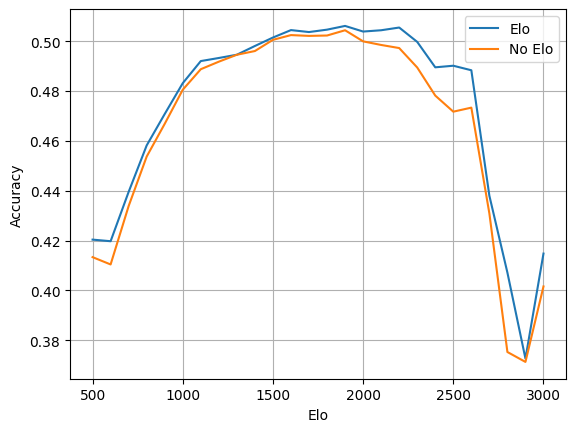

In [ ]:
plt.plot(elo_acc.keys(), elo_acc.values(), label="Elo")
plt.plot(no_elo_acc.keys(), no_elo_acc.values(), label="No Elo")
plt.legend()
plt.grid()
plt.xlabel("Elo")
plt.ylabel("Accuracy")
plt.show()

In [57]:
accuracy_df = pd.DataFrame({"elo": list(elo_acc.keys()), "elo_acc": list(elo_acc.values()), "no_elo_acc": list(no_elo_acc.values())})
accuracy_df

,elo,elo_acc,no_elo_acc
0,500,0.420400,0.413365
1,600,0.419760,0.410430
2,700,0.439564,0.433882
3,800,0.458205,0.453732
4,900,0.470823,0.466878
5,1000,0.483187,0.480552
6,1100,0.492062,0.488795
7,1200,0.493298,0.491815
8,1300,0.494608,0.494598
9,1400,0.498114,0.496090
